<a href="https://colab.research.google.com/github/palpratik56/AUNET/blob/main/Potatao_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d muhammadardiputra/potato-leaf-disease-dataset

 20% 5.00M/25.2M [00:00<00:00, 22.4MB/s]
100% 25.2M/25.2M [00:00<00:00, 81.9MB/s]


In [ ]:
!unzip /content/potato-leaf-disease-dataset.zip -d /content/

In [8]:
!nvidia-smi

Tue Apr 30 13:57:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D

from keras.preprocessing.image import ImageDataGenerator
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [10]:
train = '/content/Potato/Train'
test = '/content/Potato/Test'
val = '/content/Potato/Valid'

In [11]:
## data loading and augmentation
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 32

train_datagen= ImageDataGenerator(rescale=1.0/255,zoom_range=0.2,width_shift_range=0.2,
                               height_shift_range=0.2,fill_mode="nearest")

train_ds = train_datagen.flow_from_directory(train, target_size=(IMG_WIDTH,IMG_HEIGHT),
                               batch_size=BATCH_SIZE, class_mode="categorical", shuffle=True)

val_datagen = ImageDataGenerator(rescale= 1.0/255)

validation_ds= val_datagen.flow_from_directory(val,target_size=(IMG_HEIGHT,IMG_WIDTH),
                                 batch_size=BATCH_SIZE, class_mode="categorical",shuffle=True)

test_datagen = ImageDataGenerator(rescale= 1.0/255)

test_ds= test_datagen.flow_from_directory(test,target_size=(IMG_HEIGHT,IMG_WIDTH),
                                       batch_size=BATCH_SIZE, class_mode="categorical",shuffle=True)

Found 900 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


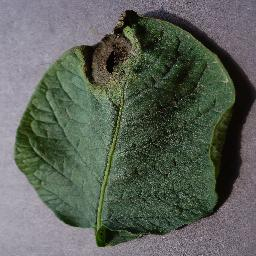

Height: 256
Width: 256
Channels: 3


In [ ]:
import os
import cv2
import random
from google.colab.patches import cv2_imshow
# Directory containing the images
directory = "/content/Potato/Valid/Potato___Late_blight"

# List all files in the directory
files = os.listdir(directory)

# Select one image randomly
random_image = random.choice(files)

# Load the randomly selected image
image = cv2.imread(os.path.join(directory, random_image))

# Display the image
cv2_imshow(image)

# Get the dimensions of the image
height, width, channels = image.shape

# Print the dimensions
print("Height:", height)
print("Width:", width)
print("Channels:", channels)

In [ ]:
for key, value in train_ds.class_indices.items():
    print(f"{key} : {value}")

Potato___Early_blight : 0
Potato___Late_blight : 1
Potato___healthy : 2


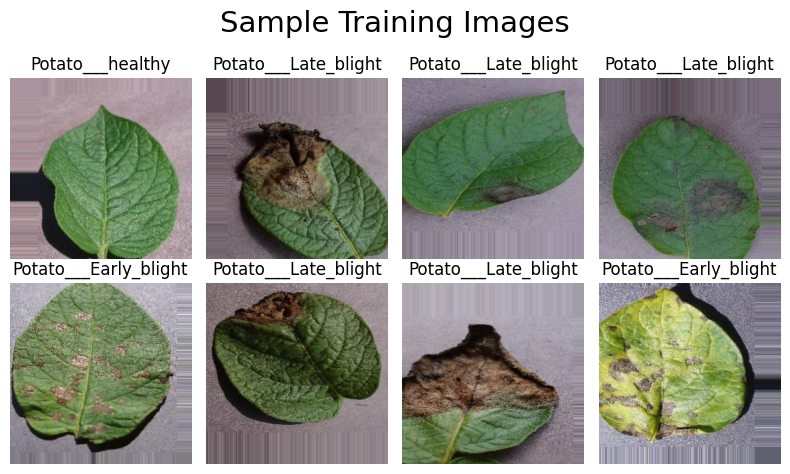

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8,5))
idx = 0
labels = {value: key for key, value in train_ds.class_indices.items()}
for i in range(2):
    for j in range(4):
        lable = labels[np.argmax(train_ds[0][1][idx])]
        ax[i,j].set_title(f"{lable}")
        ax[i, j].imshow(train_ds[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.tight_layout()
plt.show()

In [12]:
input = (256,256,3)

### **INCEPTION MODEL**

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Flatten, Dense
from keras.models import Model

def inception_module(prev_layer):
    conv1x1 = Conv2D(64, (1, 1), padding='same', activation='relu')(prev_layer)

    conv3x3 = Conv2D(128, (3, 3), padding='same', activation='relu')(prev_layer)

    conv5x5 = Conv2D(32, (5, 5), padding='same', activation='relu')(prev_layer)

    pool = MaxPooling2D((3, 3), (1, 1), padding='same')(prev_layer)
    pool_proj = Conv2D(32, (1, 1), padding='same', activation='relu')(pool)

    output = concatenate([conv1x1, conv3x3, conv5x5, pool_proj], axis=-1)

    return output

# Define input layer
input_layer = Input(shape=(256, 256, 3))

# Build Inception model
x = inception_module(input_layer)
x = inception_module(x)
x = MaxPooling2D((3, 3), (2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(3, activation='softmax')(x)

# Create model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 256, 256, 3)          0         ['input_2[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d_8 (Conv2D)           (None, 256, 256, 64)         256       ['input_2[0][0]']             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 256, 256, 128)        3584      ['input_2[0][0]']       

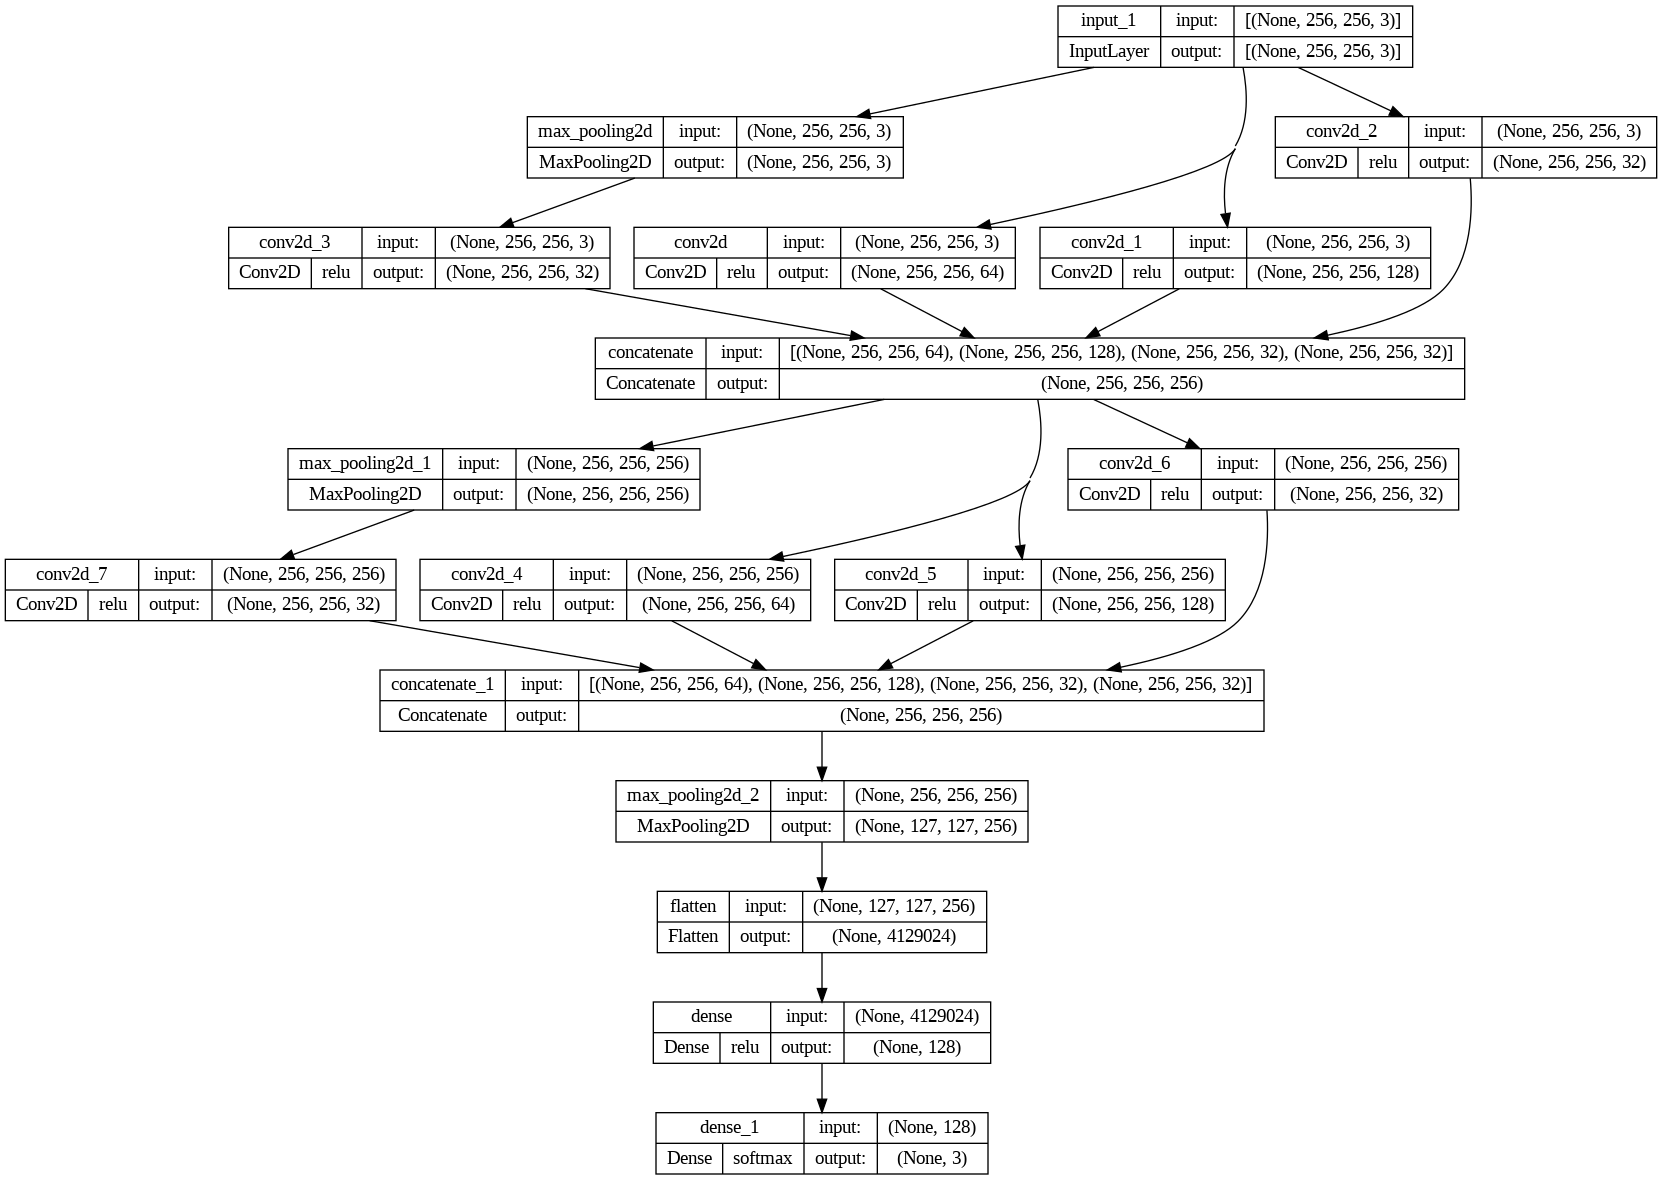

In [ ]:
from keras.utils import plot_model as pm
pm(model, show_layer_names=True, show_shapes=True, show_layer_activations=True)

### **SIMPLE CNN**

In [ ]:
tr_steps = train_ds.samples // train_ds.batch_size + 1
validation_steps = validation_ds.samples // validation_ds.batch_size + 1
tr_steps,validation_steps

(29, 10)

In [ ]:
def create_model():
  model = Sequential([
    Conv2D(32, (3, 3), padding="valid", input_shape=(256, 256, 3), activation='relu'),
    MaxPooling2D(2, 2), BatchNormalization(),

    Conv2D(64, (3, 3), padding="valid", kernel_regularizer=l2(0.00005),activation='relu'),
    MaxPooling2D(2, 2), BatchNormalization(), Dropout(0.2),

    Conv2D(64, (3, 3), padding="valid", kernel_regularizer=l2(0.00005),activation='relu'),
    # Fixed missing parenthesis
    MaxPooling2D(2, 2), BatchNormalization(),Dropout(0.2),

    Conv2D(128, (5, 5), padding="valid",activation ="relu"),
    MaxPooling2D(2, 2), BatchNormalization(),Dropout(0.2),

    Flatten(),

    Dense(128, activation="relu"), Dropout(0.3),
    Dense(3, activation="softmax")
  ])
  return model

In [ ]:
cnn_model = create_model()
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 127, 127, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                        

In [ ]:
cnn_model.compile(optimizer='adam',loss=categorical_crossentropy,metrics=['accuracy'])

### **VGG16**

In [ ]:
from keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input)
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Add custom fully connected layers
vgg = Sequential([base_model, Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

In [ ]:
# Compile the model
vgg.compile(optimizer='adam',  loss='binary_crossentropy',  metrics=['accuracy'])

In [ ]:
from keras.utils import plot_model as pm
pm(vgg, to_file='vgg.png', show_layer_names=True, show_shapes=True, show_layer_activations=True)

In [ ]:
vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 23104323 (88.14 MB)
Trainable params: 8389635 (32.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [15]:
es = EarlyStopping(monitor='val_loss', patience = 7, min_delta=0.01, verbose=1,
                   restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [ ]:
for layer in vgg.layers:
  print(layer.name, layer.input_shape, layer.output_shape)

vgg16 (None, 256, 256, 3) (None, 8, 8, 512)
flatten_3 (None, 8, 8, 512) (None, 32768)
dense_6 (None, 32768) (None, 256)
dropout_1 (None, 256) (None, 256)
dense_7 (None, 256) (None, 3)


In [13]:
from keras.models import load_model as lm
vgg = lm('/content/drive/MyDrive/vgg16.keras')

In [16]:
vgg_his = vgg.fit(train_ds,steps_per_epoch=len(train_ds), epochs=20,validation_data=validation_ds,
                  validation_steps=len(validation_ds), callbacks=[es])


Epoch 1/20
29/29 [==============================] - 32s 713ms/step - loss: 0.1828 - accuracy: 0.8944 - val_loss: 0.0997 - val_accuracy: 0.9500
Epoch 2/20
29/29 [==============================] - 17s 572ms/step - loss: 0.1622 - accuracy: 0.9089 - val_loss: 0.1489 - val_accuracy: 0.9233
Epoch 3/20
29/29 [==============================] - 18s 604ms/step - loss: 0.1677 - accuracy: 0.9022 - val_loss: 0.0928 - val_accuracy: 0.9633
Epoch 4/20
29/29 [==============================] - 17s 579ms/step - loss: 0.1650 - accuracy: 0.8967 - val_loss: 0.1097 - val_accuracy: 0.9400
Epoch 5/20
29/29 [==============================] - 17s 589ms/step - loss: 0.1491 - accuracy: 0.9111 - val_loss: 0.0792 - val_accuracy: 0.9767
Epoch 6/20
29/29 [==============================] - 17s 588ms/step - loss: 0.1377 - accuracy: 0.9211 - val_loss: 0.0926 - val_accuracy: 0.9667
Epoch 7/20
29/29 [==============================] - 18s 622ms/step - loss: 0.1530 - accuracy: 0.9089 - val_loss: 0.1133 - val_accuracy: 0.9433

In [17]:
vgg_his=vgg_his.history
train_accuracy = vgg_his['accuracy']
val_accuracy = vgg_his['val_accuracy']

train_loss = vgg_his['loss']
val_loss = vgg_his['val_loss']

In [ ]:
vgg.save('vgg16.keras')

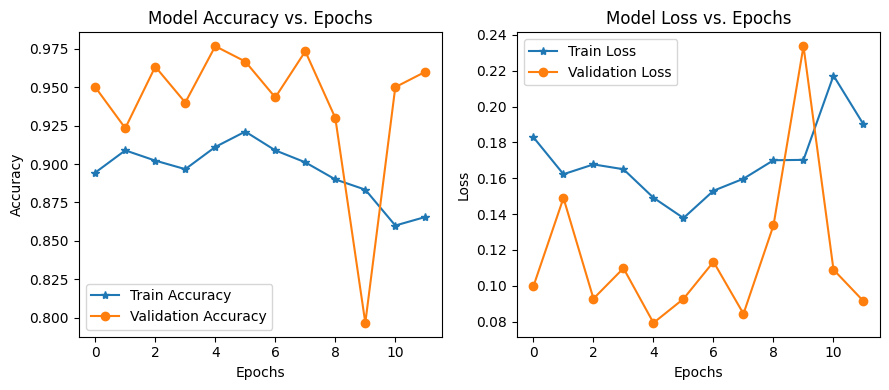

In [18]:
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.title('Model Accuracy vs. Epochs')
plt.plot(train_accuracy, '*-', label='Train Accuracy')
plt.plot(val_accuracy, 'o-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.title('Model Loss vs. Epochs')
plt.plot(train_loss, '*-', label='Train Loss')
plt.plot(val_loss, 'o-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [19]:
eval_result = vgg.evaluate(test_ds)

10/10 [==============================] - 2s 163ms/step - loss: 0.0572 - accuracy: 0.9667


In [20]:
print("Test Loss: {:0.3f}%".format(eval_result[0]*100))
print("Test Accuracy: {:0.3f}%".format(eval_result[1]*100))

Test Loss: 5.725%
Test Accuracy: 96.667%


In [21]:
true_classes = test_ds.classes
predicted_classes = np.argmax(vgg.predict(test_ds,
                                      steps=np.ceil(test_ds.samples/test_ds.batch_size)), axis=1)

10/10 [==============================] - 2s 175ms/step


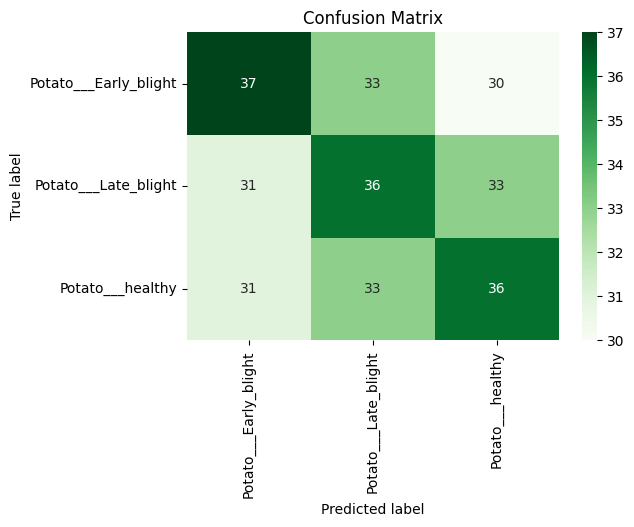

In [22]:
class_labels = list(test_ds.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [23]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
                        precision    recall  f1-score   support

Potato___Early_blight       0.37      0.37      0.37       100
 Potato___Late_blight       0.35      0.36      0.36       100
     Potato___healthy       0.36      0.36      0.36       100

             accuracy                           0.36       300
            macro avg       0.36      0.36      0.36       300
         weighted avg       0.36      0.36      0.36       300



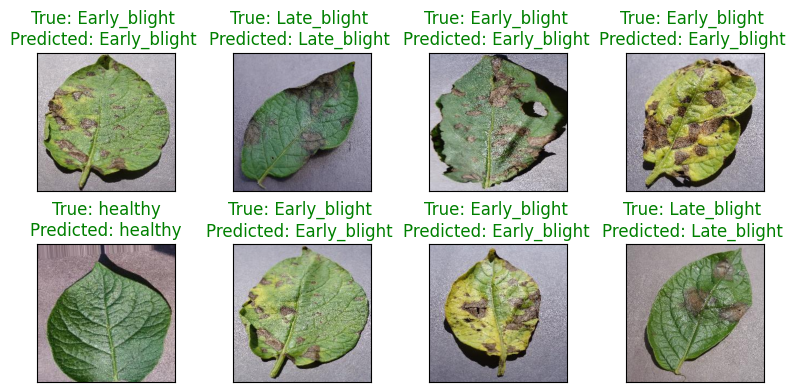

In [27]:
# Emotion classes for the dataset
disease_Classes = ['Early_blight ', 'Late_blight ', 'healthy']

# Assuming test_generator and model are already defined
batch_size = test_ds.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_ds) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(8, 4),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_ds[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_ds[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(vgg.predict(tf.expand_dims(Random_Img, axis=0), verbose=0),
                                 axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if disease_Classes[Random_Img_Label] == disease_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {disease_Classes[Random_Img_Label]}\nPredicted: {disease_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

In [28]:
true_labels = test_ds.classes
preds = vgg.predict(test_ds, steps=len(test_ds))
pred_labels = np.argmax(preds, axis=1)
classes=list(test_ds.class_indices.keys())

10/10 [==============================] - 2s 177ms/step


In [ ]:
!pip install streamlit
!pip install pyngrok

In [35]:
# prompt: python code to deploy the a cnn model by streamlit

import streamlit as st
from PIL import Image
import numpy as np

model = vgg # tf.keras.models.load_model('vgg.keras')
st.title("Potato Disease Classification")
st.text("Upload an image of a potato leaf to classify its disease.")
uploaded_file = st.file_uploader("Choose an image...", type="jpg")
if uploaded_file is not None:
    image = Image.open(uploaded_file)
    image = image.resize((256, 256))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    class_names = ['Early Blight', 'Late Blight', 'Healthy']
    st.image(uploaded_file, caption='Uploaded Image.', use_column_width=True)
    st.write("Predicted Disease:", class_names[np.argmax(prediction)])


In [36]:
!streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py

  Stopping...
^C
